Short Text Topic Classification using Gibbs Sampling Dirichlet Mixture Model

In [2]:
#To fit width of notebook to screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Libraries
from sklearn.datasets import fetch_20newsgroups
import pickle
import pandas as pd
import numpy as np
import re
from pprint import pprint

#STTM lib 
from gsdmm.gsdmm import MovieGroupProcess

#gensim
from gensim.utils import simple_preprocess

#spacy
import spacy

#Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim #important


#stopwords, mails, links etc, and emoji
from urlmarker import URL_REGEX, es_stopwords, strip_emoji

#remove deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#for listing files in directory
from os import listdir


C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [3]:
#Load dataset

archivos  = listdir('./json')
df = pd.DataFrame()

for i in archivos:
    df = df.append(pd.read_json('./json/'+i, lines=True, encoding='utf-8'), ignore_index=True)
    
# print(df.tweet.head(20))


#df = pd.read_csv('ovidio.csv')
#df1 = pd.read_json('ovidio.json', lines=True)
df.drop_duplicates(subset='tweet', inplace=True)
data = df.tweet.values.tolist()
print(df['tweet'].head(30))
print('El número de tweets es:', len(data))


0     dios, de solo pensar que mañana regreso a clas...
1                Mañana regreso a clases ¿y ustedes? :(
2     Aquí la respuesta, Campeche no vuelve a clases...
3                  Mañana regreso a clases  /Cry :"""""
4     ¿Salud física o salud mental? ¿Cómo definir la...
5     mañana regreso a clases y omg ya quiero ver qu...
6     Mañana "vuelta a clases" pero no a escuelas. L...
7     "Se está en los índices más bajos de la pandem...
8     @CentralFM_ @lopezobrador_  @Claudiashein ya #...
9     mañana regreso a clases ojalá me atropelle un ...
10    tengo una bronca pq mañana regreso a clases y ...
11    ya mañana regreso a clases de nuevo y nadie me...
12    Mañana volvemos a clases y estamo festejando c...
13    El semáforo verde en NL, envalentonó a @Adrian...
14    cuál regreso a clases, yo estaré en vacaciones...
15    Jaja mancos yo regreso a clases pasado mañana ...
16    @WRADIOMexico queremos un regreso a clases SEG...
17                Mañana regreso a clases por fa

In [4]:
#Tokenize, clean and keep allowed tags on text



def clean_sentences(sentences, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('es_core_news_sm')
    stop_words = es_stopwords()
    stop_words.extend(['mexico','méxico', 'presidente', 'amlo', 'sheinbaum', 'clases', 'regreso'])
    for words in sentences:
        words = re.sub(URL_REGEX(), '', words) #remove mails, etc..
        words = re.sub('\s+', ' ', words) #remove newline characters
        words = re.sub(strip_emoji(), '', words) #remove emoji
        words = re.sub("\'", "", words) #remove single quotes
        words = [wd for wd in simple_preprocess(str(words),deacc=True ) if wd not in stop_words] #tokenize and remove stopwords
        words = [wd for wd in words if len(wd)>3] #remove too short words
        text_out = []
        doc = nlp(" ".join(words))
        text_out.extend([token.lemma_ for token in doc if token.pos_ in allowed_postags]) #only return postagged allowed words
        
        yield(words)
        
#removing too short or too long sentences
def long_short_remove(sentences):
    text_out = []
    text_token = []
    for i, text in enumerate(sentences):
        if len(text)>1:
            text_out.append(text)
            text_token.append([text, data[i]])
    return text_out, text_token    
        

In [5]:
#we pass the tweets (or docs) to the clean function (lemmatize, remove stopwords, remove too short words) and the remove too long and too short texts. Returns two list, one with tokens and other one with token and 
# original text
clean_text, token_text_list = long_short_remove(clean_sentences(data))
print(clean_text[:20])
print(token_text_list[:20])
print(len(token_text_list))
print(len(clean_text))

[['dios', 'pensar', 'manana', 'nauseas'], ['respuesta', 'campeche', 'vuelve', 'manana', 'alturas', 'seria', 'sensato', 'aceptar', 'ciclo', 'escolar', 'revertir', 'tragedia', 'educativa', 'cosa'], ['salud', 'fisica', 'salud', 'mental', 'definir', 'prioridad', 'aulas', 'madres', 'maestras', 'maestros', 'estudiantes', 'vivido', 'encierro', 'distancia', 'distintas', 'realidades', 'tertulianaspdp'], ['manana', 'quiero', 'reprobar'], ['manana', 'vuelta', 'escuelas', 'lopez', 'obrador', 'abrirlas', 'pandemia', 'controlada', 'politica', 'nacional', 'vacunacion', 'protocolos', 'sindicatos', 'querran', 'volver', 'familias', 'supone', 'campeche'], ['indices', 'bajos', 'pandemia', 'covid', 'jalisco', 'anunciara', 'abril', 'ruta', 'presenciales'], ['centralfm_', 'lopezobrador_', 'claudiashein', 'chole', 'seguridad', 'maestros', 'alumnos', 'dejen', 'rebusbar', 'voto', 'cartel', 'morena', 'solapado'], ['manana', 'ojala', 'atropelle', 'carro'], ['bronca', 'manana', 'tareas', 'proyectos', 'semana', 'qu

In [6]:
#Function that return an ordered array (by order of importance of word) for each topic (cluster) in the model, returns a generator

def top_words_cluster(mgp):
    for i in mgp.cluster_word_distribution:
        if len(i)!=0:
            words, count = i.keys(), i.values()
            lit = sorted(zip(list(words), list(count)), key=lambda x:x[1], reverse=True) 
            #lit = zip(list(words), list(count))

            yield([list(x) for x in lit])
            
        else:
            continue       

        
def cool_dataframe(mgp):
    
    top_words = list(top_words_cluster(mgp))
    
    #for loop returns a table with values [word, count, topic] for all topics and words needed for coherence calculation
    principal_words_cluster = []
    for k, i in enumerate(top_words):
        for j in i:
            principal_words_cluster.append([j[0], j[1], k, mgp.score(j[0])[k]])
            
            
    return pd.DataFrame(principal_words_cluster, columns=['word', 'count', 'cluster', 'prob'])

        

Busqueda en grid de los valores alpha y beta para encontrar la coherencia no es necesario hacerlo con K ya que el modelo de manera automática encuentra el número de temas

In [ ]:
#Testing Coherence in a grid of alpha and beta

from gensim.models.coherencemodel import CoherenceModel 
import gensim.corpora as corpora

rangeab = range(1, 10)
vocab = set(x for doc in clean_text for x in doc)
n_length = len(vocab)
coherence_list = []
coherence_mass_list = []
run = 1
for alpha in rangeab:
    for beta in rangeab:
        print('Starting with alpha = ', alpha/10, 'and beta = ', beta/10, 'Epoch = ', run,' ----------------------------------------------------------------------------')
        #------------------------------------training the model-------------------------------------------
        mgp_grid = MovieGroupProcess(K=20, alpha=alpha/10, beta=beta/10, n_iters=10)

        y = mgp_grid.fit(clean_text, n_length)


        #-------------------------------------getting dataframe-------------------------------------------

        df_words_grid = cool_dataframe(mgp_grid) 

    

        #-----------------------------------evaluation of coherence--------------------------------------

        #gettings tokens from each topic and appending to an list of list
        coherence_tokens_grid = []
        for i in range(12):
            if len(df_words_grid[df_words_grid['cluster']==i]['word'].tolist())!=0:
                coherence_tokens_grid.append(df_words_grid[df_words_grid['cluster']==i]['word'].tolist())
        #------------------------------------Coherence-------------------------
        #getting dictionary, corpus and coherence (for coherence of the type c_something, we need the texts too)
        dictionary_gen = corpora.Dictionary(clean_text)

        corpus = [dictionary_gen.doc2bow(text) for text in clean_text]

#         cm = CoherenceModel(topics=coherence_tokens_grid,texts=clean_text, corpus=corpus, dictionary=dictionary_gen, coherence='c_v')
        cm_mass = CoherenceModel(topics=coherence_tokens_grid,texts=clean_text, corpus=corpus, dictionary=dictionary_gen, coherence='u_mass')

#         coherence = cm.get_coherence()
        coherence_mass = cm_mass.get_coherence()
#         print('The value of the coherence (for c_v is: ', coherence, 'The value of u_mass coherence is: ',coherence_mass)
        print('The value of u_mass coherence is: ',coherence_mass)

#         coherence_list.append([coherence, 2*alpha/10, 2*beta/10])
        coherence_mass_list.append([coherence_mass, alpha/10, beta/10])
        run = run+1

# print('The value of the coherence (for c_v is: ', coherence_list, 'The value of u_mass coherence is: ',coherence_mass_list)
print('The value of u_mass coherence is: ',coherence_mass_list)

In [ ]:
pprint(coherence_mass_list)

In [7]:
#training the model

mgp = MovieGroupProcess(K=20, alpha=0.3, beta=0.9, n_iters=20)
vocab = set(x for doc in clean_text for x in doc)
n_length = len(vocab)

y = mgp.fit(clean_text, n_length)

In stage 0: transferred 3892 clusters with 20 clusters populated
In stage 1: transferred 1945 clusters with 20 clusters populated
In stage 2: transferred 807 clusters with 18 clusters populated
In stage 3: transferred 585 clusters with 16 clusters populated
In stage 4: transferred 499 clusters with 14 clusters populated
In stage 5: transferred 405 clusters with 14 clusters populated
In stage 6: transferred 391 clusters with 16 clusters populated
In stage 7: transferred 359 clusters with 11 clusters populated
In stage 8: transferred 329 clusters with 12 clusters populated
In stage 9: transferred 348 clusters with 11 clusters populated
In stage 10: transferred 338 clusters with 14 clusters populated
In stage 11: transferred 326 clusters with 12 clusters populated
In stage 12: transferred 312 clusters with 13 clusters populated
In stage 13: transferred 313 clusters with 14 clusters populated
In stage 14: transferred 347 clusters with 15 clusters populated
In stage 15: transferred 338 clus

In [8]:
#save the model
with open('regreso_a_clases_presenciales.model', "wb") as f:
    pickle.dump(mgp, f)

In [9]:
#various information

doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic: ', doc_count)
print('*'*20)

#topic sorted by the number of document thery are allocated to 
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

print('Total number of words in cluster: ',mgp.cluster_word_count)

# mgp.cluster_word_distribution[0]


Number of documents per topic:  [  18  373    9    0  729   66   16 2268    1    0  720    2    0    0
    1    9   24    0    0    0]
********************
Most important clusters (by number of docs inside): [ 7  4 10  1  5 16  0  6 15  2]
Total number of words in cluster:  [230, 2462, 120, 0, 6084, 677, 264, 16196, 3, 0, 7738, 24, 0, 0, 9, 134, 290, 0, 0, 0]


In [10]:
mgp.choose_best_label(doc_count)

(16, 0.17979035949555064)

In [11]:

tranf = np.zeros(len(doc_count))
k=1        
s=1
for j,i in enumerate(list(doc_count)):       
    if i==0:
        tranf[j] = k
        s=k
        k+=1
    if i!=0:
        tranf[j] = s
        
top_index_tranf = [int(j-tranf[j-1]) for j in top_index]
    

print('The tranformed index for the most important clusters list is: ', top_index_tranf)
print('Most important clusters (by number of docs inside): ', top_index)

The tranformed index for the most important clusters list is:  [6, 3, 8, 0, 4, 12, -7, 5, 11, 1]
Most important clusters (by number of docs inside):  [ 7  4 10  1  5 16  0  6 15  2]


In [12]:
#getting nice formatted dataframe

df_words = cool_dataframe(mgp)

#removes any row that has a empty cell...usefull to remove clusters that do, not have words
#df_words.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False).reset_index()

df_words.head(20)


word  count  cluster      prob
0         vida      6        0  0.057746
1      peligro      5        0  0.106577
2         real      5        0  0.057746
3         duda      5        0  0.057746
4       radica      5        0  0.092523
5       camino      5        0  0.092523
6   exponerlos      5        0  0.135911
7     contagio      5        0  0.118302
8       muerte      5        0  0.092523
9       cambio      5        0  0.092523
10     retorno      5        0  0.106577
11      normal      5        0  0.092523
12     derecho      5        0  0.106577
13     seegene      4        0  0.106577
14     pruebas      4        0  0.106577
15       covid      3        0  0.076081
16       apoya      3        0  0.076081
17    faciales      3        0  0.118302
18        leer      3        0  0.057746
19     campana      2        0  0.106577

In [13]:
print('DataFrame ordenado por probabilidad para el tópico x:\n',df_words.loc[df_words['cluster']==1].sort_values(by='prob', ascending=False).head(25))

DataFrame ordenado por probabilidad para el tópico x:
       word  count  cluster     prob
988   nice      1        1  0.31829
842   pega      1        1  0.31829
244   chau      3        1  0.31829
245   debo      3        1  0.31829
246   malo      3        1  0.31829
805   izzi      1        1  0.31829
482   tita      1        1  0.31829
508   caer      1        1  0.31829
649   zone      1        1  0.31829
1054  toca      1        1  0.31829
252   hare      3        1  0.31829
412   pies      2        1  0.31829
254   hora      3        1  0.31829
255   same      3        1  0.31829
678   tome      1        1  0.31829
844   more      1        1  0.31829
409   dara      2        1  0.31829
243   baja      3        1  0.31829
242   jaja      3        1  0.31829
803   wifi      1        1  0.31829
420   pase      2        1  0.31829
224   sigo      4        1  0.31829
425   mayo      2        1  0.31829
593   duro      1        1  0.31829
847   this      1        1  0.31829


Coherence metric for the model

In [14]:
from gensim.models.coherencemodel import CoherenceModel 
import gensim.corpora as corpora

#gettings tokens from each topic and appending to an list of list
coherence_tokens = []
for i in range(10):
    if len(df_words[df_words['cluster']==i]['word'].tolist())!=0:
        coherence_tokens.append(df_words[df_words['cluster']==i]['word'].tolist())
#------------------------------------Coherence-------------------------
#getting dictionary, corpus and coherence (for coherence of the type c_something, we need the texts too)
dictionary_gen = corpora.Dictionary(clean_text)

corpus = [dictionary_gen.doc2bow(text) for text in clean_text]

# cm = CoherenceModel(topics=coherence_tokens,texts=clean_text, corpus=corpus, dictionary=dictionary_gen, coherence='c_v')
cm_mass = CoherenceModel(topics=coherence_tokens,texts=clean_text, corpus=corpus, dictionary=dictionary_gen, coherence='u_mass')

# coherence = cm.get_coherence()
coherence_mass = cm_mass.get_coherence()
# print('The value of the coherence (for c_v is: ', coherence)
print('The value of u_mass coherence is: ',coherence_mass)

The value of u_mass coherence is:  -7.63646410470146


In C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

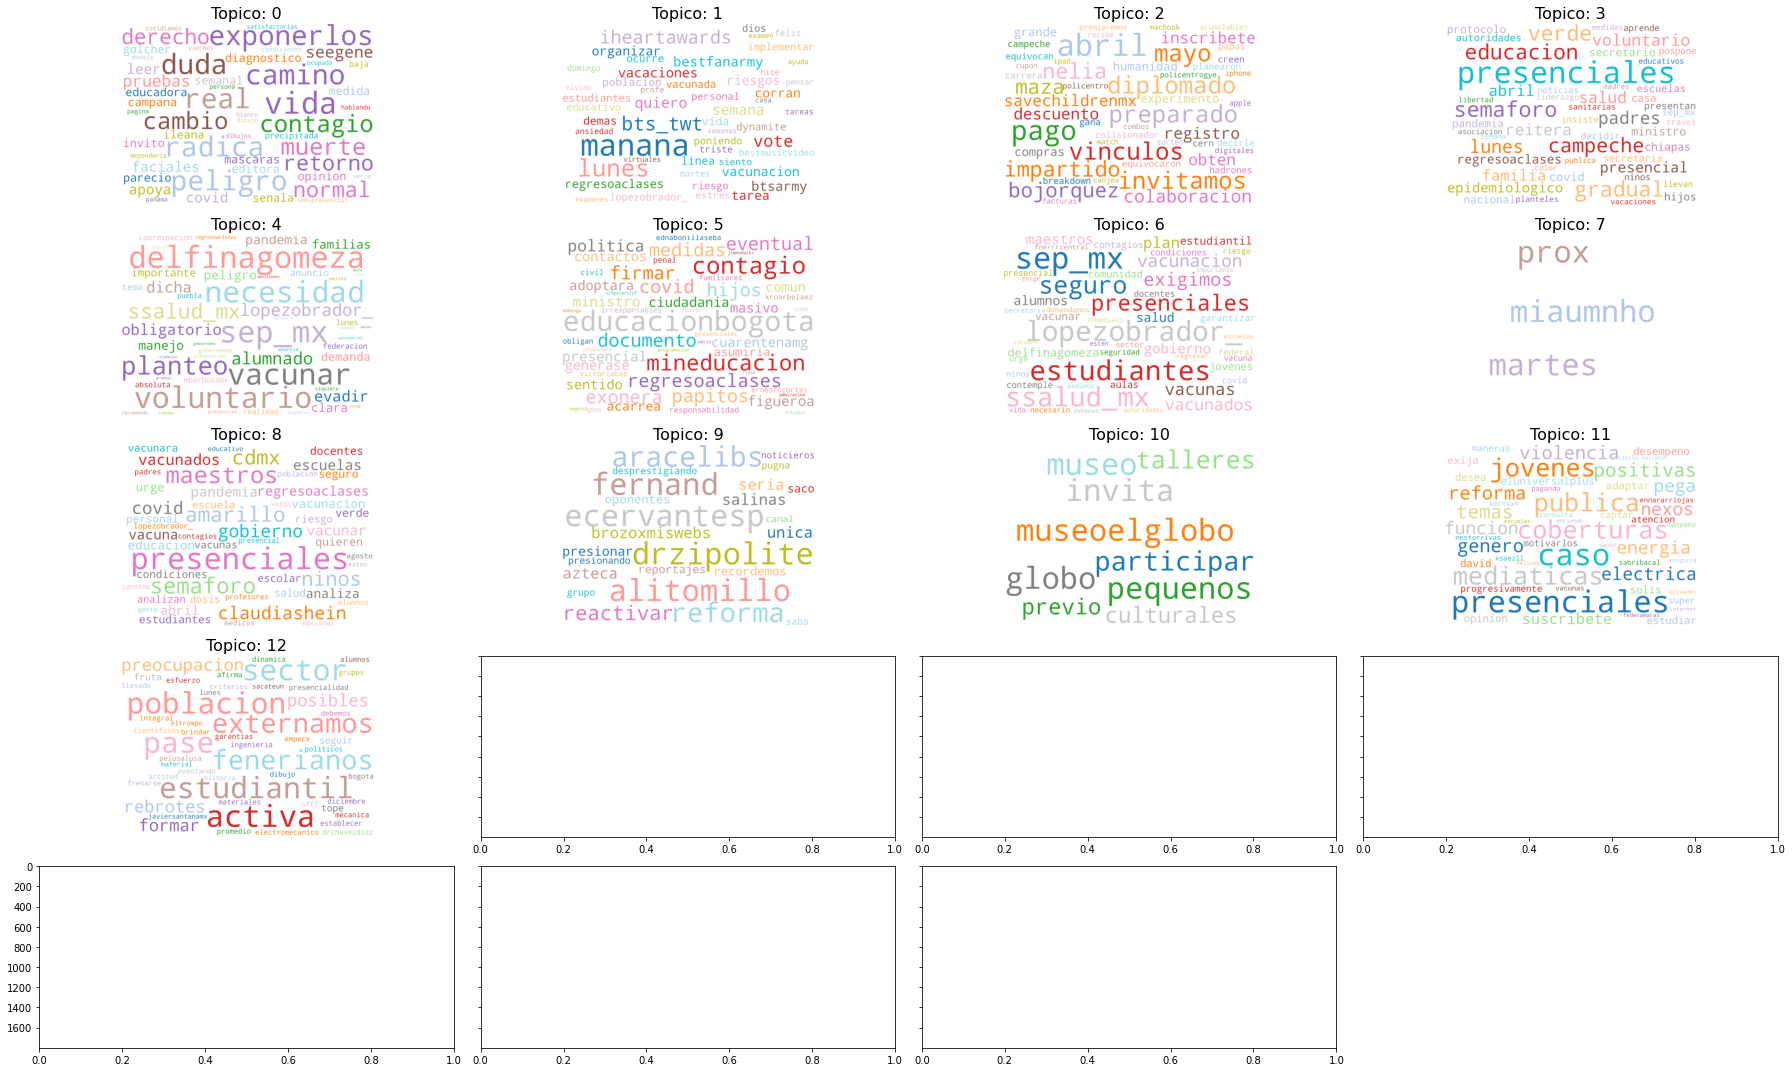

In [15]:
#wordcloud plot from word count

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from os import path
%matplotlib inline

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab20',
                  prefer_horizontal=1.0)



fig, axes = plt.subplots(5, 4, figsize=(25, 15), sharey=True)

for i, ax in enumerate(axes.flatten()):
    if len(df_words[df_words['cluster']==i]['word'])>0:
        fig.add_subplot(ax)
        #generating the dictionary lists of frequencies fr the wordcloud
        data = df_words[df_words['cluster']==i][['word', 'count']]
        data1 = list(data['word'])
        data2 = list(data['count'])
        dictionary = dict(zip(data1, data2))
        cloud.generate_from_frequencies(dictionary, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topico: '+str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        fig.add_subplot(ax)
        

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
# plt.show()
plt.savefig('./words_map.png', dpi=300, transparent=True, bbox_inches='tight')

In [40]:
#Aquí se puede ver a que cluster pertenece una frase u oración de texto, por la misma condición del modelo se asume que cada oración tiene sólo un tópico
print((token_text_list[0])[1],'   ',(token_text_list[0])[0])
mgp.score((token_text_list[0])[0])

dios, de solo pensar que mañana regreso a clases me dieron nauseas     ['dios', 'pensar', 'manana', 'nauseas']


[1.7394128654802135e-06,
 7.613618710726999e-08,
 1.510782272302896e-06,
 5.687749184873825e-07,
 0.00034015601217020705,
 1.9401709356113915e-06,
 7.613618710726999e-08,
 0.9989425504990119,
 7.613618710726999e-08,
 6.830609764981498e-06,
 5.340492208354753e-06,
 7.613618710726999e-08,
 0.0005715591590958478,
 1.0348490319321243e-06,
 7.262929113953625e-06,
 5.8637693701025885e-06,
 0.00010948709779453776,
 7.613618710726999e-08,
 2.7332456861379493e-06,
 1.0415148241746174e-06]

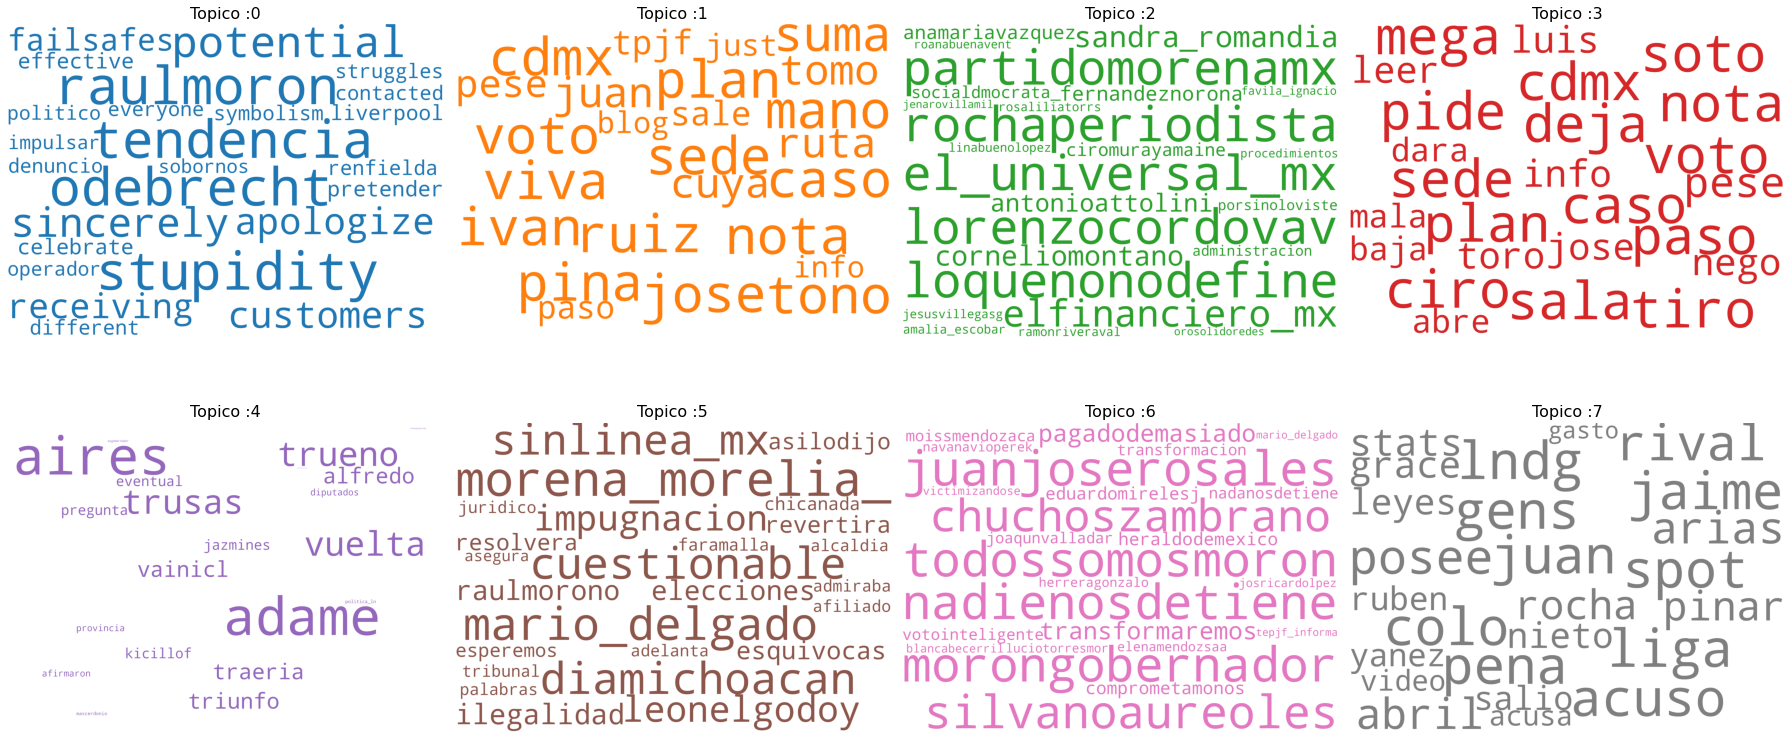

In [15]:
#wordcloud plot from prob. The model cluster by countmthose are the cluster that should be used, not the prob.

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=25,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)



fig1, axes1 = plt.subplots(2, 4, figsize=(25, 12), sharey=True)

for i, ax in enumerate(axes1.flatten()):
    if len(df_words[df_words['cluster']==i]['word'])!=0:
        fig1.add_subplot(ax)
        #generating the dictionary lists of frequencies fr the wordcloud
        dataw = df_words[df_words['cluster']==i][['word', 'prob']]
        data11 = list(dataw['word'])
        data21 = list(dataw['prob'])
        dictionaryw = dict(zip(data11, data21))
        cloud.generate_from_frequencies(dictionaryw, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topico :'+str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

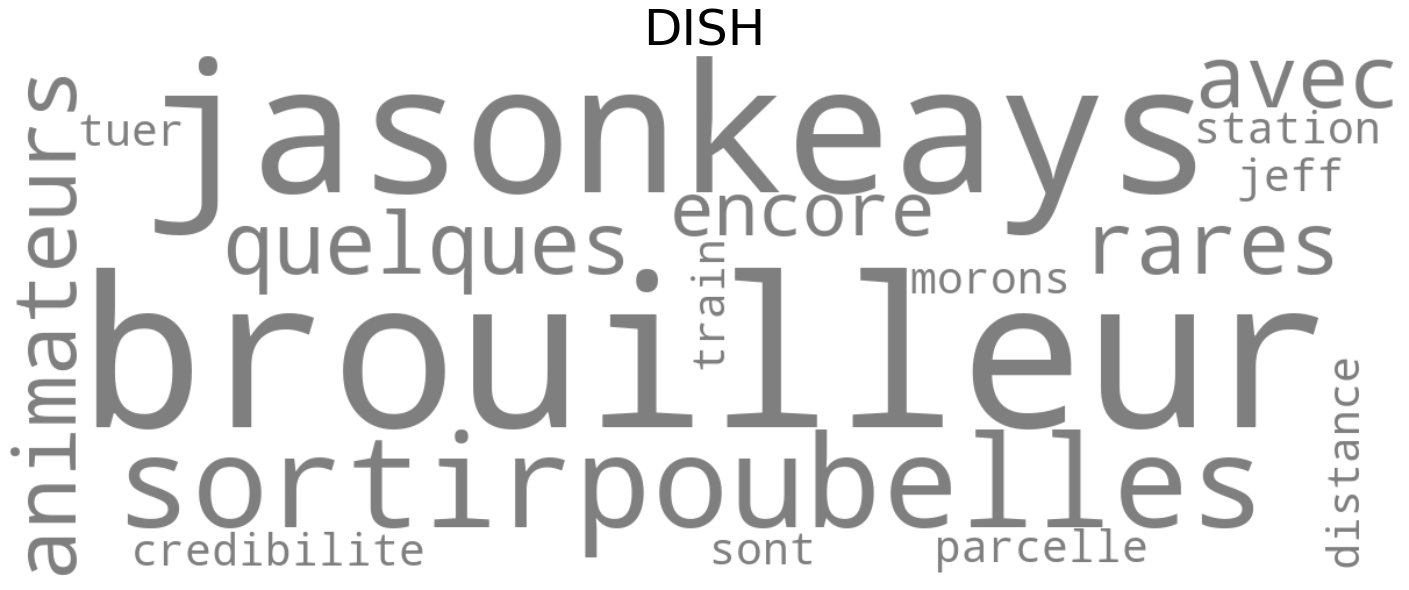

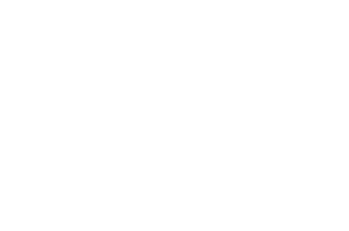

In [18]:
#wordcloud using a mask (in this case fromo morena logo), it is not necessary to do a for loop to plot every theme

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from os import path

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
mask_image = np.array(Image.open('DISH.png'))


cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  min_font_size=4,
                  max_words=1000,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  mask=mask_image,
                  contour_width=10,
                  contour_color='steelblue')

plt.figure(figsize=(25,10))

#generating the dictionary lists of frequencies
data = df_words[df_words['cluster']==2][['word', 'count']]
data1 = list(data['word'])
data2 = list(data['count'])
dictionary = dict(zip(data1, data2))
cloud.generate_from_frequencies(dictionary)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('DISH', fontdict=dict(size=50))

plt.figure()
#plt.imshow(mask_image, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')

plt.show()

C:\Users\lance\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



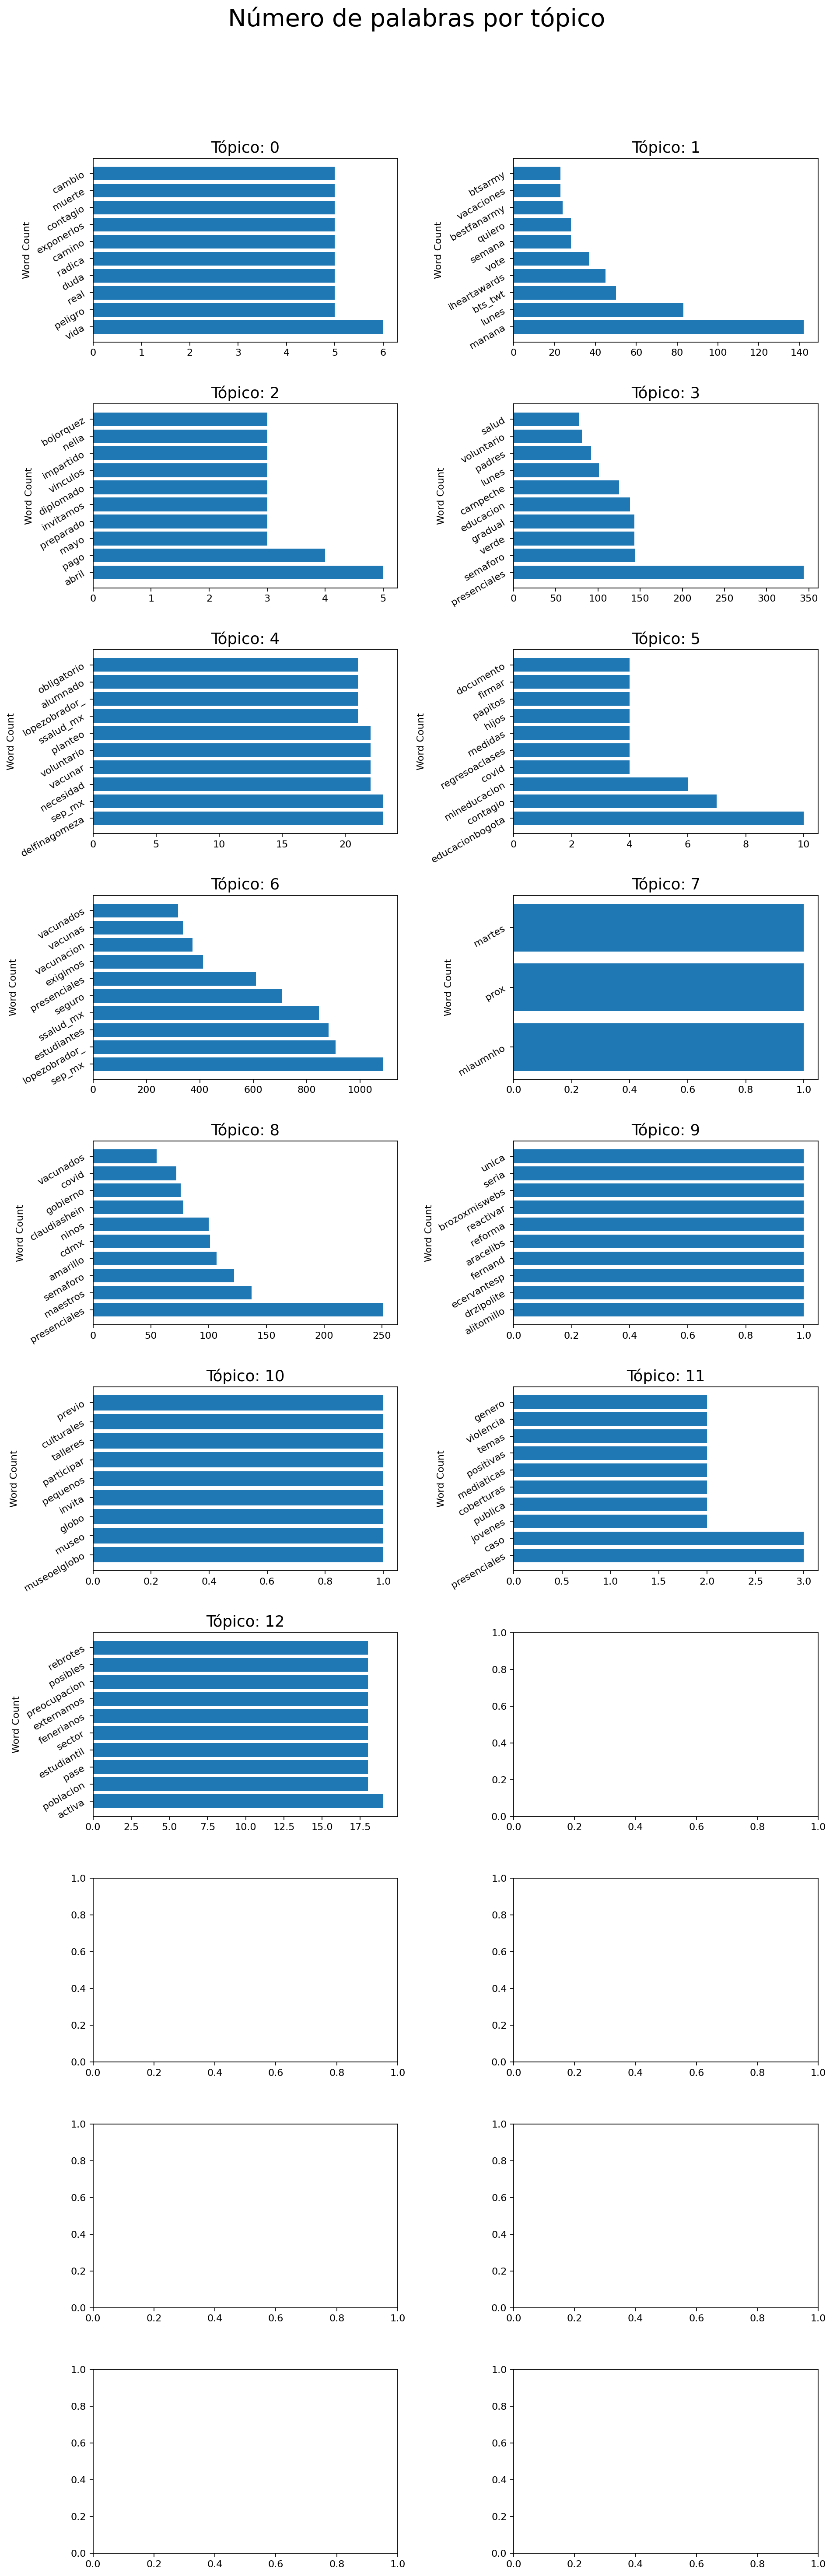

In [16]:
#word frequency per topic

fig, axes = plt.subplots(10,2, figsize=(12,35),  dpi=160)

for i, ax in enumerate(axes.flatten()):
    if len(df_words[df_words['cluster']==i]['word'])!=0:
        fig.add_subplot(ax)
        plt.savefig('books_read.png')
        plt_word, plt_count = df_words[df_words['cluster']==i]['word'],df_words[df_words['cluster']==i]['count']
        ax.barh(plt_word.iloc[:10],plt_count.iloc[:10])
        #, color=cols[i])
        ax.set_ylabel('Word Count')
        #, color=cols[i])
        ax.set_title('Tópico: '+str(i), fontsize=16)
        #, color=cols[i])
        ax.set_yticklabels(plt_word.iloc[:10], rotation=30, horizontalalignment='right')
        #, color=cols[i])

fig.patch.set_facecolor('#ffffff')
fig.tight_layout(w_pad=2)  
fig.suptitle('Número de palabras por tópico', fontsize=25, y=1.05)
plt.show()

In [18]:
#same as above but using plotly 
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import plotly.express as px
data = df_words[df_words['cluster']==0][['word','count']]

data1 = data[:15].copy()

fig = px.histogram(data1, x='count', y='word', histfunc='avg', orientation='h', hover_name='word')
fig.show()


In [16]:
print(mgp.cluster_word_count)
print(doc_count)

[74, 15, 8240, 633, 48, 15, 320, 222, 18, 0, 6293, 535, 0, 0, 0, 0, 15514, 92, 2212, 0]
[   6    1  845   44    4    1   31   16    1    0  678   43    0    0
    0    0 2217    5  344    0]


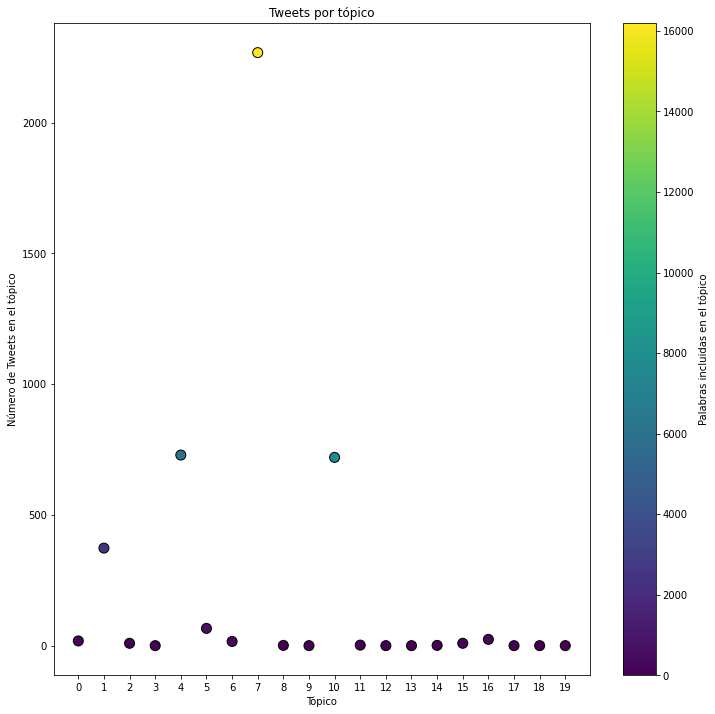

In [56]:
#Grafica de palabras por cluster
import plotly.express as px1
# map(str, range(10))
words_clusters = pd.DataFrame(list(zip(mgp.cluster_word_count, doc_count, np.arange(len(mgp.cluster_word_count)))), columns=['Words_Per_Cluster', 'Doc_Count', 'Cluster'])
# fig1 = px1.scatter(words_clusters, x="Words_Per_Cluster", y="Doc_Count", size='Doc_Count' ,size_max=70, hover_name='cluster', color='cluster')
# fig1.show()

# print(words_clusters["Cluster"])
# words_clusters.plot.scatter(x="Cluster", y="Doc_Count", c="Words_Per_Cluster", colormap='viridis', figsize=(12,12), s=100, edgecolors='black')



fig, ax = plt.subplots(figsize=(12,12))

scatterTweets = ax.scatter(words_clusters['Cluster'], words_clusters['Doc_Count'], c=words_clusters['Words_Per_Cluster'], s=100,  edgecolors='black')
cbar = fig.colorbar(scatterTweets)
cbar.set_label("Palabras incluidas en el tópico", loc='center')
ax.set_xticks(np.arange(len(words_clusters['Cluster'])))

# produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatterTweets.legend_elements(func=lambda x: x), loc="upper left", title="Palabras por tópico")
# ax.add_artist(legend1)

# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylabel('Número de Tweets en el tópico')
ax.set_xlabel('Tópico')
ax.set_title('Tweets por tópico')

# Label with specially formatted floats
# ax.set_xlim(right=15)  # adjust xlim to fit labels




plt.show()

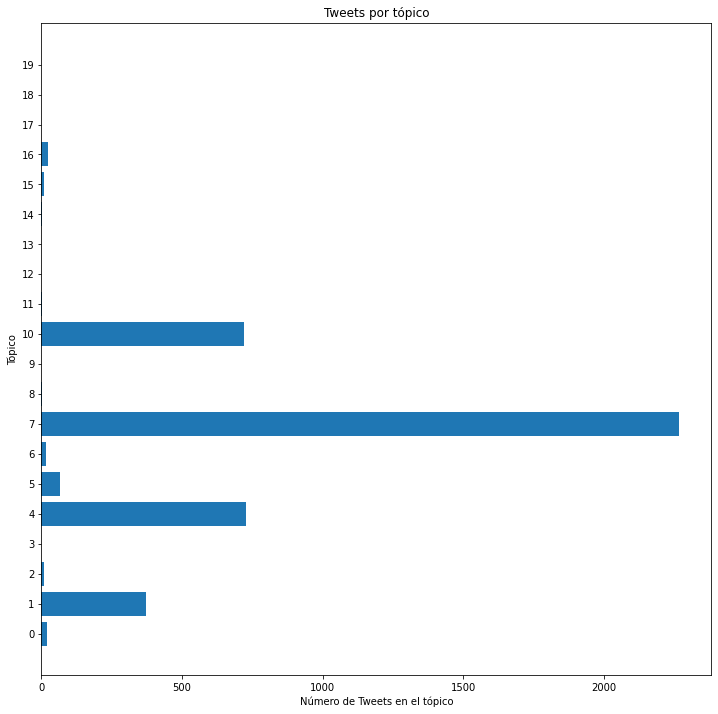

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

hbars = ax.barh(words_clusters['Cluster'], words_clusters['Doc_Count'],  align='center')
ax.set_yticks(np.arange(len(words_clusters['Cluster'])))

# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Número de Tweets en el tópico')
ax.set_ylabel('Tópico')
ax.set_title('Tweets por tópico')


plt.show()

In [ ]:
#Grafica de palabras por cluster
import plotly.express as px1
# map(str, range(10))
words_clusters = pd.DataFrame(list(zip(mgp.cluster_word_count, doc_count, np.arange(len(mgp.cluster_word_count)))), columns=['Words_Per_Cluster', 'Doc_Count', 'Cluster'])
# fig1 = px1.scatter(words_clusters, x="Words_Per_Cluster", y="Doc_Count", size='Doc_Count' ,size_max=70, hover_name='cluster', color='cluster')
# fig1.show()

print(words_clusters)
words_clusters.plot.scatter(x="Cluster", y="Doc_Count", c="Words_Per_Cluster", colormap='viridis' ,figsize=(12,12), s=100, edgecolors='black')


plt.show()

In [23]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

words_clusters = pd.DataFrame(list(zip(mgp.cluster_word_count, doc_count, map(str, range(10)))), columns=['Words_Per_Cluster', 'Doc_Count', 'cluster'])

source = ColumnDataSource(data=words_clusters)

p = figure(title='Word count per topic', plot_width=1500, plot_height=700)
p.vbar(x='Words_Per_Cluster', width=30,  bottom=0, top='Doc_Count', source=source, color='firebrick')
output_notebook()

show(p)

ModuleNotFoundError: No module named 'bokeh'

In [25]:
mgp.choose_best_label(df.tweet[100][100:])

(6, 0.19665122402426347)

In [12]:
pprint(coherence_mass_list)

[[-7.91463316096231, 0.1, 0.1],
 [-9.536605005139302, 0.1, 0.2],
 [-7.979532201887493, 0.1, 0.3],
 [-9.236147774036363, 0.1, 0.4],
 [-8.19872739234587, 0.1, 0.5],
 [-6.8312079777356915, 0.1, 0.6],
 [-7.866768079410914, 0.1, 0.7],
 [-14.854300025772458, 0.1, 0.8],
 [-8.312015741185245, 0.1, 0.9],
 [-8.653662432292467, 0.2, 0.1],
 [-10.187799405609978, 0.2, 0.2],
 [-9.565694933564558, 0.2, 0.3],
 [-9.758815948369321, 0.2, 0.4],
 [-8.563476625525825, 0.2, 0.5],
 [-9.153264108630678, 0.2, 0.6],
 [-7.607791025253703, 0.2, 0.7],
 [-8.517968609530351, 0.2, 0.8],
 [-6.68947082719412, 0.2, 0.9],
 [-7.737281065312506, 0.3, 0.1],
 [-9.225735443784686, 0.3, 0.2],
 [-9.612574004645987, 0.3, 0.3],
 [-8.487107079561321, 0.3, 0.4],
 [-6.712305015495491, 0.3, 0.5],
 [-9.419547012113988, 0.3, 0.6],
 [-8.754084699413214, 0.3, 0.7],
 [-8.579783327008643, 0.3, 0.8],
 [-6.3632688159009305, 0.3, 0.9],
 [-7.541778834145372, 0.4, 0.1],
 [-9.215388952468116, 0.4, 0.2],
 [-8.329692872711963, 0.4, 0.3],
 [-6.7417

In [ ]:
coherence_df= pd.DataFrame(coherence_list, columns=['coherence', 'alpha', 'beta'])
coherence_df.head()

Coherence metric for one model

pyLDAvis implementación con este modelo (intento...en pausa

In [32]:
#Matrix of topic terms distribution

df_LDAvis = df_words.word.copy()
df_LDAvis.drop_duplicates()


topic_terms = []
for i in df_LDAvis:
    topic_terms.append(mgp.score(i))
    
    
#Matrix of document-topics probabilities
document_topics = []
for j in token_text_list:
    document_topics.append(mgp.score(j[0]))
    

#doc_length, in the order of document-topics matrix
doc_length = []
for j in token_text_list:
    doc_length.append(len(j[0]))

#vocabulary a list of all the words in the corpus
vocab = df_LDAvis.values.copy()

#term frequency

term_freq = df_words['count'].values.copy()


In [33]:
print(topic_terms[:10])
print(document_topics[:10])
print(doc_length[:10])
print(vocab[:10])
print(term_freq[:10])

[[0.0017654221632280836, 0.0017654221632280836, 0.0017654221632280836, 0.0017654221632280836, 0.02646981590695904, 0.06594338796121725, 0.0017654221632280836, 0.01038809634510384, 0.0017654221632280836, 0.00831331193378762, 0.1833623959132791, 0.0017654221632280836, 0.10570442648141942, 0.0017654221632280836, 0.34532822583113454, 0.23330527366836185, 0.0017654221632280836, 0.0017654221632280836, 0.0017654221632280836, 0.0017654221632280836], [0.0021899261259581805, 0.0021899261259581805, 0.0021899261259581805, 0.0021899261259581805, 0.03230594319920253, 0.07765316710514222, 0.0021899261259581805, 0.012823376998959813, 0.0021899261259581805, 0.0015924560011634534, 0.138745292677545, 0.0021899261259581805, 0.11810161682112141, 0.0021899261259581805, 0.3421254455617767, 0.25037358812359056, 0.0021899261259581805, 0.0021899261259581805, 0.0021899261259581805, 0.0021899261259581805], [0.0026522366908141156, 0.0026522366908141156, 0.0026522366908141156, 0.0026522366908141156, 0.0384961998257